In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp  
import math
from tqdm import tqdm

In [58]:
def Corr(l1,l2):
    '''
    ## Description:
        Correlation function between two lists of the same length.

    ## Returns:
        corr (float): correlation between the two lists

    ## Parameters:
        l1 (list): list of predictions of the first classifier (1 or 0)
        l2 (list): list of predicions of the second classifier / true values (1 or 0)
    '''

    N = len(l1)
    # Get the correlation
    corr = 0
    for i in range(len(l1)):
        corr += (2*l1[i]-1)*(2*l2[i]-1)/N**2  # Scaling to -1/N,1/N
    return corr

In [63]:
def QUBO(L, x, y, lambda_):
    '''
    ## Description:
        Defines QUBO problem

    ## Returns:
    Q: QUBO matrix


    ## Parameters:
        L: list of weak classifiers (0 and 1)
        x: data
        y: labels
        lambda_: regularization parameter
    '''
    N = len(L)
    S = len(x)

    # Define QUBO matrix
    Q = np.zeros((N, N))

    for i in range(N):
        for j in range(i, N):
            if j != i:
                Q[i, j] = Corr(L[i].predict(x), L[j].predict(x))
                Q[j, i] = Q[i, j]
            else:
                Q[i, i] = lambda_ - 2*Corr(np.array(L[i].predict(x)), np.array(y))


    return Q


In [26]:
def simulated_annealing(func, init_state, T, reanneal, max_iter):
    """
        ## Description:
            Simulated annealing algorithm
            Finds the minimum of a function func using simulated annealing.

        ## Returns:
            current_state: final solution
            current_energy: final energy

        ## Parameters:
            func: function to minimize
            init_state (array of 0 and 1): initial solution
            T: initial temperature
            reanneal: number of iterations before reannealing
            max_iter: maximum number of iterations
    """

    # Initialize
    current_state = init_state
    current_energy = func(current_state)

    for iteration in range(max_iter):
        new_state = current_state.copy()

        # Flip one bit
        index = np.random.randint(0,len(new_state))
        new_state[index] = 1 - new_state[index]

        # Compute new energy
        new_energy = func(new_state)

        # If new energy is lower, accept new state
        if new_energy < current_energy:
            current_state = new_state
            current_energy = new_energy
        
        # If new energy is higher, accept new state with probability
        else:
            p = np.exp(-(new_energy - current_energy)/T)      # Compute probability
            if np.random.rand() < p:
                current_state = new_state
                current_energy = new_energy
        
        # Update temperature
        if iteration % reanneal == 0:
            T = T*0.95
    
    return current_state, current_energy  

In [27]:
def RGS(L,x,y,lambda_):
    '''
    ## Description:
        Implements RGS method using weak classifiers and Simulated Annealing

    ## Returns:
    w (array): solution of the QUBO problem

    ## Parameters:
        L (list): list of weak classifiers
        x (array): data
        y (array): labels
        lambda_ (scalar): regularization parameter
    '''

    # Define QUBO matrix
    Q = QUBO(L,x,y,lambda_)

    # Define QUBO problem
    
    def f(w):
        s=0
        for i in range(len(w)):
            for j in range(len(w)):
                s+= Q[i,j]*w[i]*w[j]
        return s
    
    # Define initial state
    init_state = np.zeros(len(L))
    
    # Run simulated annealing
    w, energy = simulated_annealing(f,init_state,1,40,1000)

    return w, energy


In [35]:
def PredictRGS(L,w,x):
    
    N = len(L)
    S = len(x)
    
    predictions = []

    for i in range(N):
        predictions.append(2 * L[i].predict(x) - 1)

    predictions = np.array(predictions)

    # Calculate T
    T = 0
    for i in range(S):
        for j in range(N):
            T+= w[j]*predictions[j][i]
    T = np.sign(T)

    # Calculate predictions 
    C = []
    for i in range(S):
        p = 0
        for j in range(N):
            p += w[j]*predictions[j][i]
        p = np.sign(p-T)
        C.append(p)
    
    # Replace -1 by 0
    for i in range(len(C)):
        if C[i] == -1:
            C[i] = 0
    return C


In [89]:
def PredictRGS_probas(L,w,x,p):

    N = len(L)
    S = len(x)
    
    predictions = []

    for i in range(N):
        predictions.append([])
        proba = L[i].predict_proba(x)
        for j in range(S):          
            if proba[j][0] > p:
                predictions[i].append(0)
            else:
                predictions[i].append(1)

    predictions = np.array(predictions)

    # Calculate T
    T = 0
    for i in range(S):
        for j in range(N):
            T+= w[j]*predictions[j][i]
    T = np.sign(T)

    # Calculate predictions 
    C = []
    for i in range(S):
        p = 0
        for j in range(N):
            p += w[j]*predictions[j][i]
        p = np.sign(p-T)
        C.append(p)
    
    # Replace -1 by 0
    for i in range(len(C)):
        if C[i] == -1:
            C[i] = 0
    return C

In [29]:
adult  = pd.read_csv("adult.csv", sep=',',header=0)
adult = adult.drop('education', axis=1)
adult.replace(['Cambodia', 'China', 'Hong', 'India','Iran', 'Japan', 'Laos', 'Philippines','Taiwan', 'Thailand','Vietnam'],'Asia', inplace = True)
adult.replace(['Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador','Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua','Peru', 'Puerto-Rico', 'Trinadad&Tobago', 'South'], 'Center & South America', inplace = True)
adult.replace(['England', 'France', 'Germany', 'Greece', 'Holand-Netherlands', 'Hungary', 'Ireland', 'Italy', 'Poland', 'Portugal', 'Scotland', 'Yugoslavia'], 'Europe', inplace = True)
adult.replace(['United-States', 'Canada'], 'Canada&USA', inplace = True)

In [30]:
features = adult.drop('income', axis = 1)

target = []
for x in adult['income']:
    if x == '>50K':
        target.append(1)
    else: 
        target.append(0)


features_matrix = pd.get_dummies(features)

# Replace bools by 0 and 1
features_matrix.replace([False, True], [0, 1], inplace = True)

In [31]:
# Looking at the distribution of the labels (in percentage)
print('Percentage of people with income >50K: ', round(sum(target)/len(target)*100,2), '%')
print('Percentage of people with income <=50K: ', round((1-sum(target)/len(target))*100,2), '%')

Percentage of people with income >50K:  23.93 %
Percentage of people with income <=50K:  76.07 %


In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_matrix, target, test_size=0.2, random_state=42)

**RANDOM FOREST**
(max_depth = 5)

<Axes: >

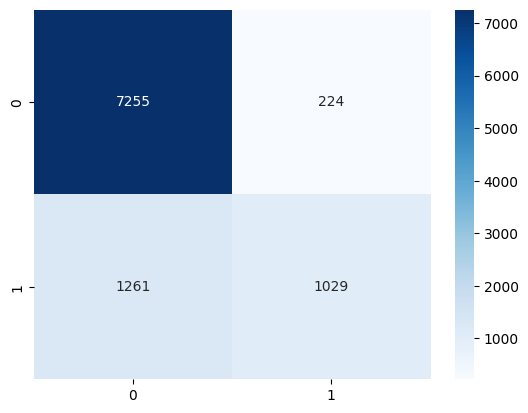

In [107]:
# Training a random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0)
clf.fit(x_train, y_train)

# Printing a confusion matrix using seaborn with better colors
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

In [108]:
# Recall and precision of the RF
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Recall: ', recall)
print('Precision: ', precision)

Recall:  0.4493449781659389
Precision:  0.8212290502793296


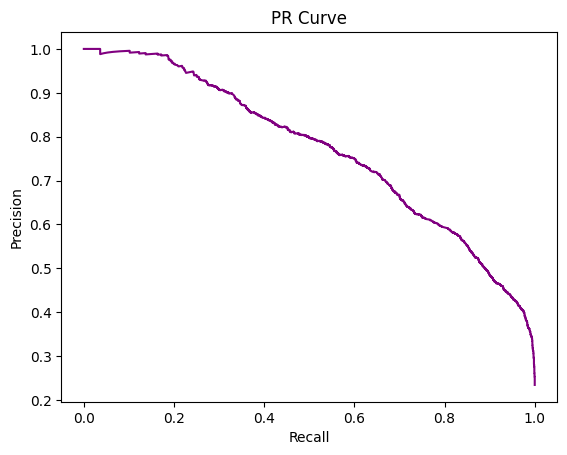

0.7691207884324105

In [109]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
# PR Curve
y_score = clf.predict_proba(x_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fig, ax  = plt.subplots()
ax.plot(recall, precision, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()

# AUC
auc(recall, precision)

**QBOOST**

In [91]:
# Training 30 decision trees
from sklearn.tree import DecisionTreeClassifier

L = []
for i in range(50):
    x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=i)
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(x_train_small, y_train_small)
    L.append(clf)

In [92]:
w = RGS(L,x_train,y_train,0)[0]

In [93]:
w

array([1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.])

In [ ]:
# Minimum through exhaustive search
Q = QUBO(L,x_train,y_train,2)
def f(w):
    s=0
    for i in range(len(w)):
        for j in range(len(w)):
            s+= Q[i,j]*w[i]*w[j]
    return s

compteur = 0
state = np.zeros(len(L))
m = f(state)
# Finds the minimum of the QUBO function through exhaustive search
for i in range(2**len(L)):
    compteur += 1
    state = np.zeros(len(L))
    for j in range(len(L)):
        state[j] = (i//2**j)%2
    if f(state) < m:
        m = f(state)
        w = state
print('Minimum found: ', m)



KeyboardInterrupt: 

<Axes: >

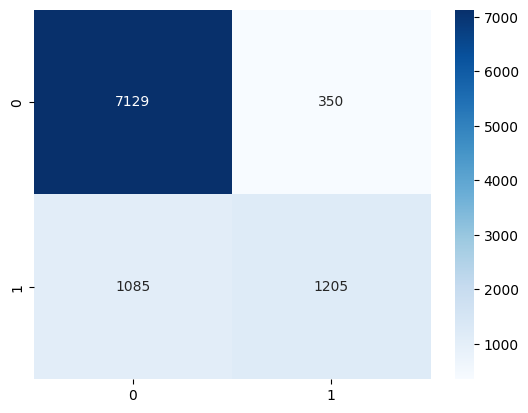

In [94]:
y_pred = PredictRGS(L,w,x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

In [95]:
# Recall and precision of the RGS
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Recall: ', recall)
print('Precision: ', precision)

Recall:  0.5262008733624454
Precision:  0.77491961414791


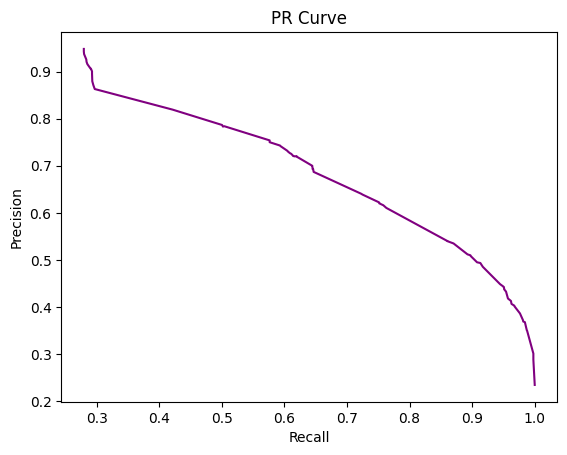

In [112]:
# PR Curve

P = np.linspace(0,1,200)
preci= []
rec = []

for p in P:
    y_predprime = PredictRGS_probas(L,w,x_test,p)
    cm = confusion_matrix(y_test, y_predprime)
    recallp = cm[1,1]/(cm[1,1]+cm[1,0])
    precisionp = cm[1,1]/(cm[1,1]+cm[0,1])
    preci.append(precisionp)
    rec.append(recallp)

fig, ax  = plt.subplots()
ax.plot(rec, preci, color = "purple")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
plt.show()


In [113]:
# AUC
auc(rec, preci)

0.4885172757468829

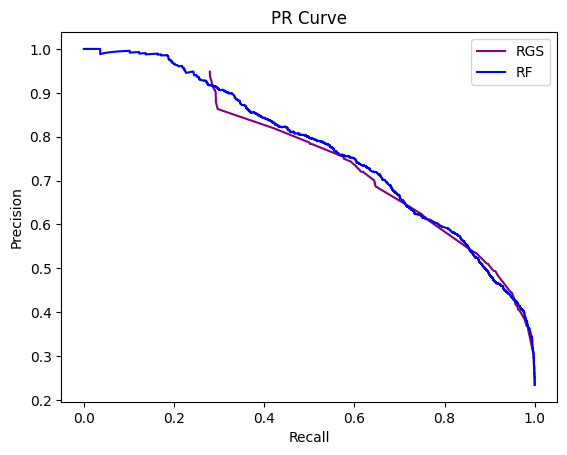

In [114]:
# Plotting PR curves of the RF and the RGS
fig, ax  = plt.subplots()
ax.plot(rec, preci, color = "purple", label = "RGS")
ax.plot(recall, precision, color = "blue", label = "RF")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve")
ax.legend()
plt.show()


In [61]:
# Training 30 decision trees and 30 knn

from sklearn.neighbors import KNeighborsClassifier

L = []
for i in range(40):
    x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=i)
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(x_train_small, y_train_small)
    L.append(clf)

for i in range(10):
    x_train_small, _, y_train_small, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=i) 
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(x_train_small, y_train_small)
    L.append(neigh)

In [64]:
w = RGS(L,x_train,y_train,0)[0]

In [67]:
w

array([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.])

<Axes: >

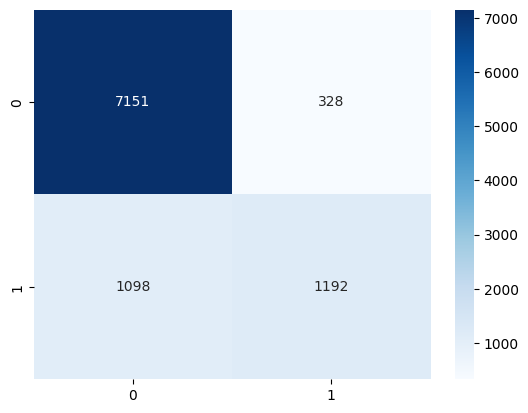

In [65]:
y_pred = PredictRGS(L,w,x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

In [69]:
# Recall and precision of the RGS classifier
recall = cm[1,1]/(cm[1,1]+cm[1,0])
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Recall: ', recall)
print('Precision: ', precision)

Recall:  0.5205240174672489
Precision:  0.7842105263157895
